In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import warnings

from src import data, centroids, matrix_filtering, communicatin_metrics, plotting,correlations

%matplotlib inline

!date -I

2024-05-18


# F-TRACT

Replication of the work presented in paper *Communication dynamics in the human connectome shape the cortex-wide propagation of direct electrical stimulation* by Seguin et al. using F-TRACT dataset. Our goal is to calculate correlation between response probability (amplitude, peak onset, peak delay) after intracranial stimulation with network communication metrics calculated on structural connectomes. We want to see if there is a relationship between the response and the structure combined with communication models.

#### Settings

- `FTRACT_SHORT` True or false, if true, use responses 50 ms long, if false, use 200 ms responses. 
- `PARCELLATION` There are three sets of structural connectivity matrices in this repository based on parcellations named below. 
- `MIN_STREAMLINE` The minimal number of treamlines between two regions to consider an edge between them while creating group-averaged connectome from connectomes of individual subjects. Does not affect connectomes which were already downloaded as group average (see README in external data folder). 
- `GRAPH_DENSITY` Desired density of connectome, used for filtering of all the connectivity matrices after they are loaded.
- `ED_THRESHOLD` [mm] Region pairs closer to each other than the threshold are excludes from the analysis. We use 0 in most of our experiments, but Seguin et al. used 20 mm (they show results with 0 mm in robustness analysis in Appendix).
- `ONLY_MICA_RH` Consider only Mica-Mics structural connectivity matrix created using Rosen and Halgren's preprocessing in the analysis. Otherwise all matrices available for selected parcellation are used. Set to true only for Glasser parcellation.

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION = "MNI-HCP-MMP1"

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = False

ED_THRESHOLD = 0
MIN_STREAMLINES = 5
GRAPH_DENSITY = 0.25

ONLY_MICA_RH = False # True

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

In [3]:
fig_dir = f"ftract_results/{PARCELLATION}/{MIN_STREAMLINES}/ED{ED_THRESHOLD}/{GRAPH_DENSITY}/{'short' if FTRACT_SHORT else 'long'}/"
%mkdir -p  {paths.path_figures(fig_dir)}

if ONLY_MICA_RH:
    fig_dir = f"ftract_results/{PARCELLATION}/{MIN_STREAMLINES}/ED{ED_THRESHOLD}/{GRAPH_DENSITY}/{'short' if FTRACT_SHORT else 'long'}/mica_rh"

## Load data

### Load F-TRACT data

The Functional Brain Tractography project (F-TRACT) summary dataset used in this section was prepared by Jedynak et el., it consists of several matrices characterizing the brain's response to intracranial electrical stimulation.

The F-TRACT project aggregated iEEG data from 550 patients with drug-resistant epilepsy measured during $29\,055$ stimulations using 2.77 million pairs of intracerebral depth electrodes. In order to mitigate the impact of epileptogenic processes in further analyses, recordings with a high likelihood of pathological activity were excluded. The results were projected onto a number of parcellations, this notebook expects Deskian-Killiany (DKT) or Glasser (MNI-HCP-MMP1) parcellation. 

The recorded evoked potentials were baseline corrected and $z$-scored. Stimulus response was considered significant if the $z$-scored evoked potential over $z = 5$ was observed. The response amplitude was defined as the first peak of $z$-scored evoked potential above the $z = 5$ threshold. Using that, two whole-brain group-level matrices were constructed. Entries $P_{ij} \in [0,1]$ of response probability matrix $P$ characterize the probability that we observe a significant response as described above in ROI $j$ after stimulation of $i$. Entries $A_{ij} \in \mathbb{R}_{>0}$ of response amplitude matrix $A$ capture the median response amplitude of significant responses.

In [4]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, response_onset_delay, response_peak_delay, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

# one of the structural matrices contains less regions, so we delete the following two
# such that the resulting structural and functional matrices are comparable (the indices
# were found experimentally)
ids_to_delete_in_dkt = [37,3]

if PARCELLATION == "DKT":
    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        response_onset_delay = np.delete(response_onset_delay,ids_to_delete_in_dkt,axis=a)
        response_peak_delay = np.delete(response_peak_delay,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

### Load Euclidean distances

The distances between centroids of individual regions in the brain.

In [5]:
if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    
elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)

### Define mask

Define which region pairs include in the analysis based on the methodology by Seguin et al.:

- probability
    - a minimum of 100 stimulation experiments
    - recordings were acquired across a minimum of 5 different patients
- amplitude
    - a minimum of 100 significant stimulation responses

In [18]:
mask = np.logical_and(np.logical_and(n_stim > 100, n_impl > 5),ED>ED_THRESHOLD)
mask_amp = (n_stim*response_probability)>=100

Text(0.5, 1.0, 'Amplitude mask: (n_stim*P)>100')

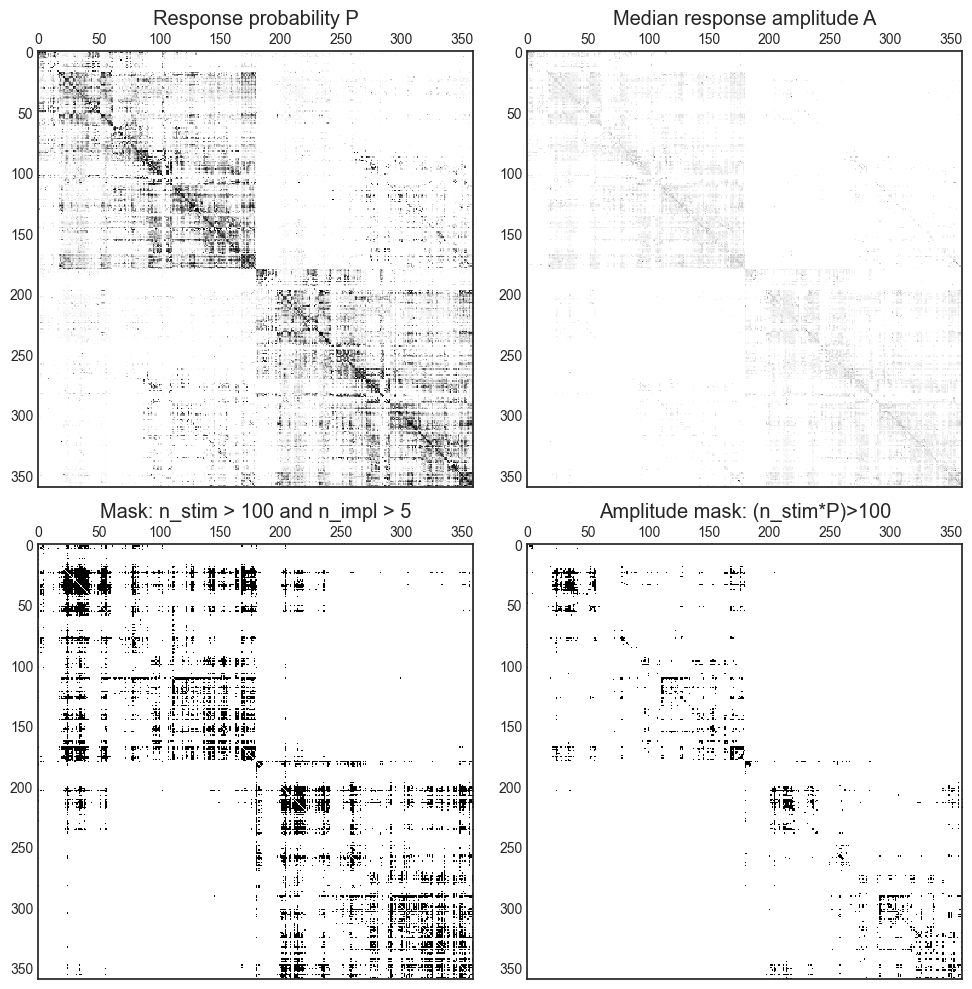

In [19]:
plt.style.use('seaborn-v0_8-white')
fig, axs = plt.subplots(2, 2, figsize=(10,10),tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(np.log(response_amplitude))
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)
axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

Text(0.5, 1.0, 'Response peak delay PD')

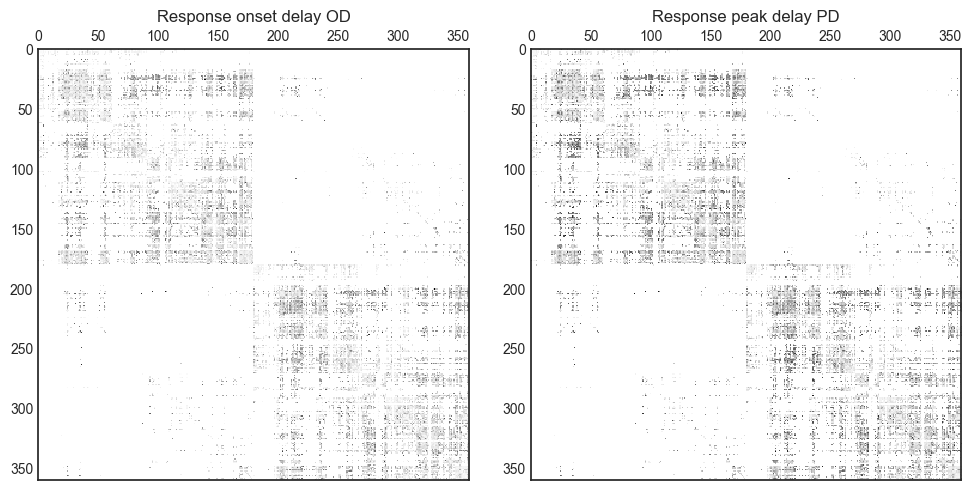

In [8]:
plt.style.use('seaborn-v0_8-white')
fig, axs = plt.subplots(1, 2,figsize=(10,5), tight_layout=True)
axs[0].matshow(response_onset_delay)
axs[0].set_title("Response onset delay OD")
axs[1].matshow(response_peak_delay)
axs[1].set_title("Response peak delay PD")

### Load structural connectivity data

Load structural connectivity data and Euclidean distances based on parcellation. `SC_matrices` is a list of tuples `(str, 2D np.array, 2D np.array, 2D np.array)` consisting of: 
- name in a form [dataset]_[group averaging method]
- structural connectivity weights
- structural connectivity lengths
- logarithm of structural connectivity weights

Group averaging method is a string indicating how the group representative connectome was created, options are:
- `simple` simple averaging
- `cons` consensus thresholding
- `dist` distance-dependent consensus thresholding
- `rh` Rosen and Halgren's method

In [9]:
if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=MIN_STREAMLINES)
    
elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED,min_streamlines_count=MIN_STREAMLINES)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


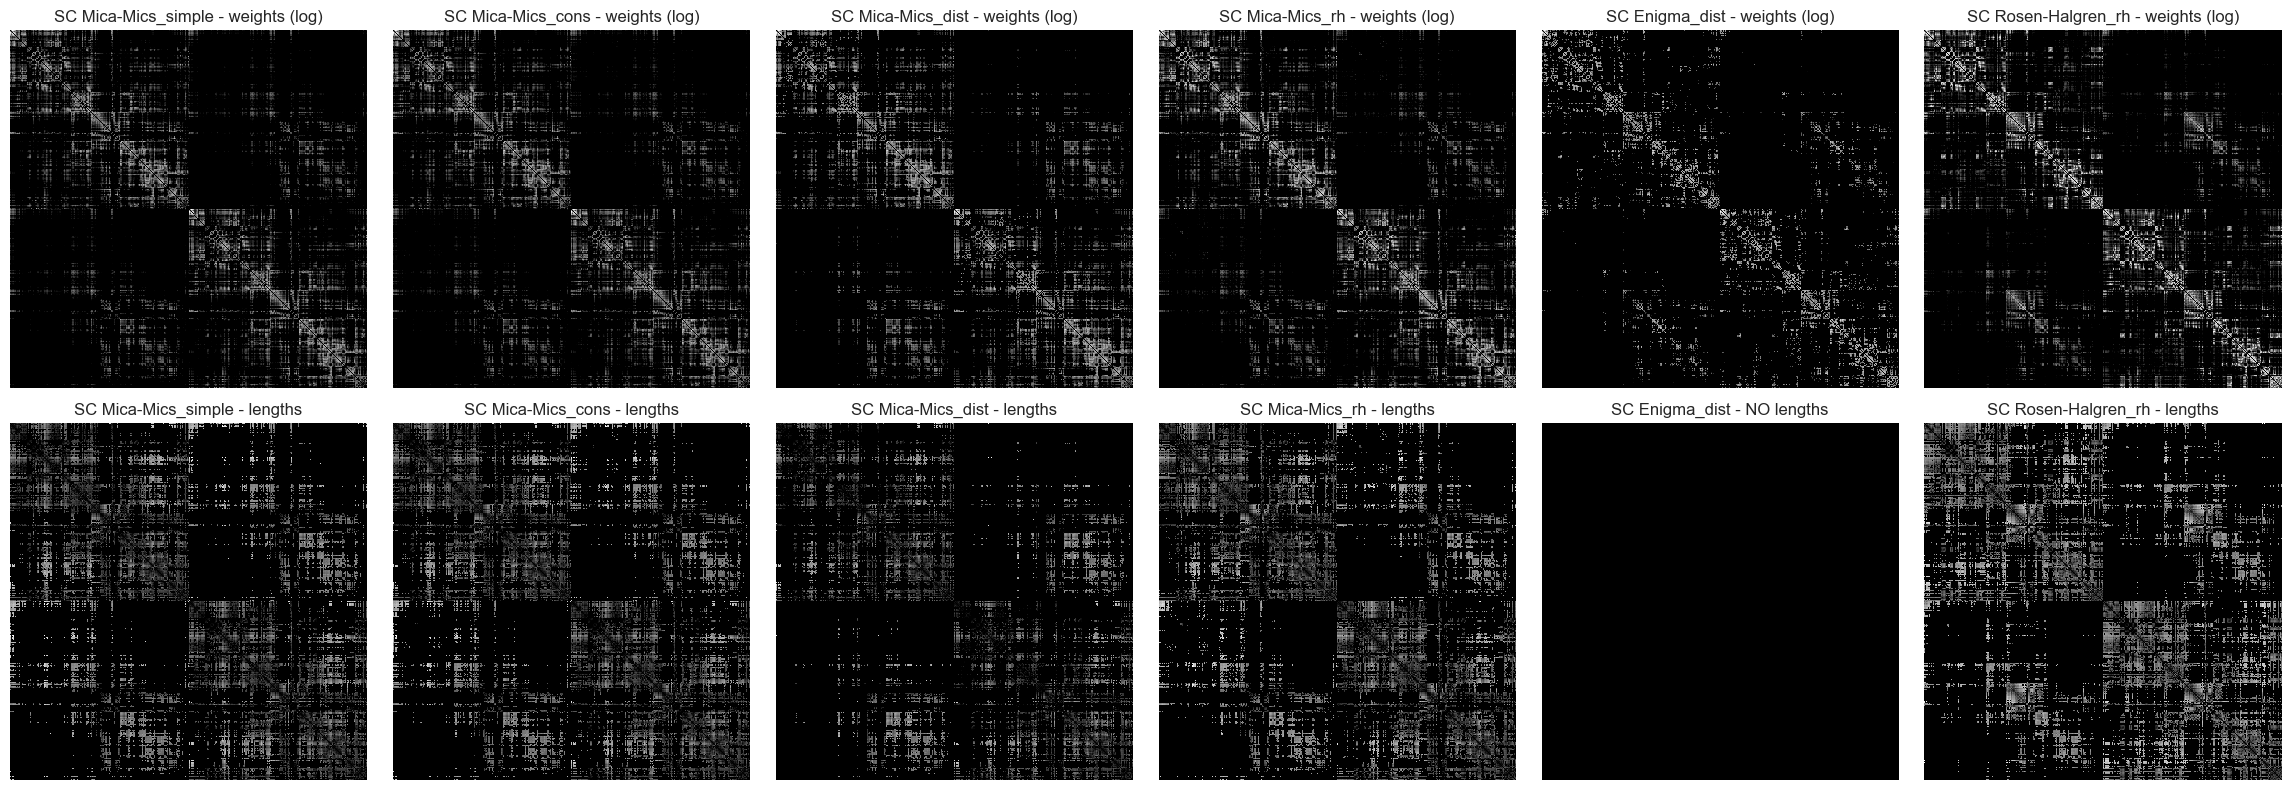

In [10]:
SC_matrices = matrix_filtering.filter_matrices_based_on_density(SC_matrices,GRAPH_DENSITY)
plotting.plot_structural_matrices_weight_lengths(SC_matrices,fig_dir,PARCELLATION)

## Prepare dataframes

For each dataset and response characteristic (probability, amplitude, onset delay and peak delay), a dataframe with columns corresponding to Euclidean distance, structural connectivity and communication metrics and rows corresponding to region pairs. 

|column name | description |
|---|---|
| ED    | Euclidean distance
| SC_W   | structural connectivity - weights
| SC_L   | structural connectivity - lengths
| SPE   | shortest path efficiency
| SPE_W | shortest path efficiency with 1/SC_W instead of SC_L 
| COM   | communicability
| SI    | search information
| SI_L  | search information with SC_L for path length
| NAV   | navigation efficiency
| DIF   | diffusion efficiency

In [11]:
def fill_df(df,mask,metrics_dict):
    for m in metrics_dict:
        matrix = metrics_dict[m]
        df[m] = matrix[mask].flatten()

In [12]:
stat_data = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    if ONLY_MICA_RH and name != "Mica-Mics_rh":
        continue

    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

    df_probability = pd.DataFrame({"response_probability":response_probability[mask].flatten()})
    df_amplitude = pd.DataFrame({"response_amplitude":response_amplitude[mask_amp].flatten()})
    df_onset_delay = pd.DataFrame({"response_onset_delay":response_onset_delay[mask].flatten()})
    df_peak_delay = pd.DataFrame({"response_peak_delay":response_peak_delay[mask].flatten()})

    fill_df(df_probability,mask,metrics_dict)
    fill_df(df_amplitude,mask_amp,metrics_dict)
    fill_df(df_onset_delay,mask,metrics_dict)
    fill_df(df_peak_delay,mask,metrics_dict)

    stat_data[name] = {"probability":df_probability,"amplitude":df_amplitude,"onset_delay":df_onset_delay,"peak_delay":df_peak_delay}

See the dataframe for Enigma dataset and response probability below as an example:

In [13]:
stat_data["Enigma_dist"]["probability"]

,response_probability,ED,SC_W,SPE_W,COM,SI,NAV,DIF
0,0.665,32.704258,6181.399617,9766.730627,0.101525,5.584361,0.030577,0.002551
1,0.502,4.387056,201188.991199,201188.991199,0.730811,0.559887,0.227943,0.034957
2,0.342,9.158334,46770.128584,59360.060496,0.316216,2.664779,0.109190,0.016923
3,0.559,20.061667,4987.549570,25342.749088,0.087000,5.893963,0.049846,0.006910
4,0.619,28.988965,5363.650040,8731.513259,0.076866,5.789079,0.034496,0.003922
...,...,...,...,...,...,...,...,...
10182,0.707,20.833223,115.572727,2272.500516,0.015026,7.962564,0.048000,0.001950
10183,0.174,43.063384,1.000000,1746.250000,0.000571,14.815221,0.023222,0.002712
10184,0.563,26.239325,1.000000,2230.441653,0.005866,14.815221,0.038111,0.002633
10185,0.586,24.249962,1.000000,2014.653069,0.001518,14.815221,0.041237,0.002742


## Calculate correlations

Calculate correlations for the response with the other columns in the dataframe. Do this for all datasets and response characteristics.

In [14]:
list_of_SC_names = []

for name,_,_,_ in SC_matrices:
    list_of_SC_names.append(name)

list_of_SC_names

['Mica-Mics_simple',
 'Mica-Mics_cons',
 'Mica-Mics_dist',
 'Mica-Mics_rh',
 'Enigma_dist',
 'Rosen-Halgren_rh']

In [15]:
results = {}
results_partial = {}

if PARCELLATION == "DKT":
    response_types_list = ["probability","amplitude"]
else:
    response_types_list = ["probability","amplitude","onset_delay","peak_delay"]

for response_type in response_types_list:
    corr_list =  []
    partial_corr_list = []

    for name,_,_,_ in SC_matrices:
        if ONLY_MICA_RH and name != "Mica-Mics_rh":
            continue

        corr_list.append(pg.pairwise_corr(stat_data[name][response_type],columns=[f"response_{response_type}"], method='spearman').round(3))
        partial_corr_list.append(correlations.partial_corr_ED(stat_data[name][response_type],f"response_{response_type}","spearman"))

    results[response_type] = pd.concat(corr_list, keys=list_of_SC_names).reset_index(names=["dataset","-"])
    results_partial[response_type] = pd.concat(partial_corr_list, keys=list_of_SC_names).reset_index(names=["dataset","-"])

    for r in [results[response_type],results_partial[response_type]]:
        correlations.abs_r_to_dataframe(r)
        correlations.sigf_sign_to_dataframe(r)

## Plot results

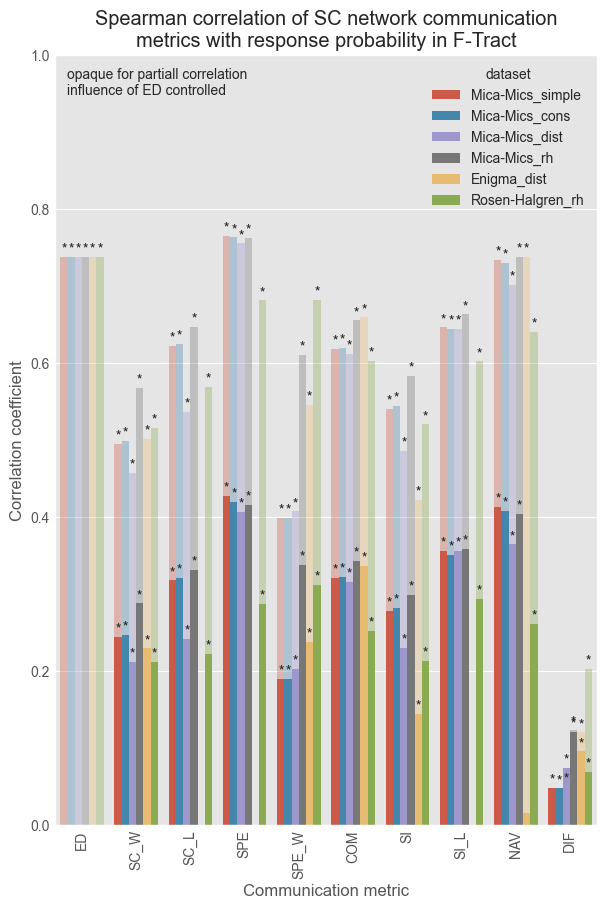

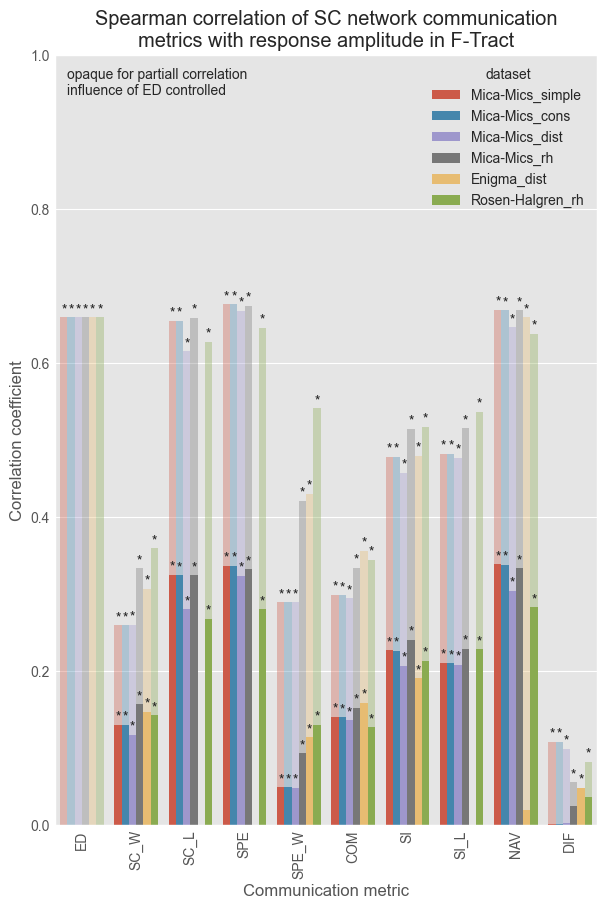

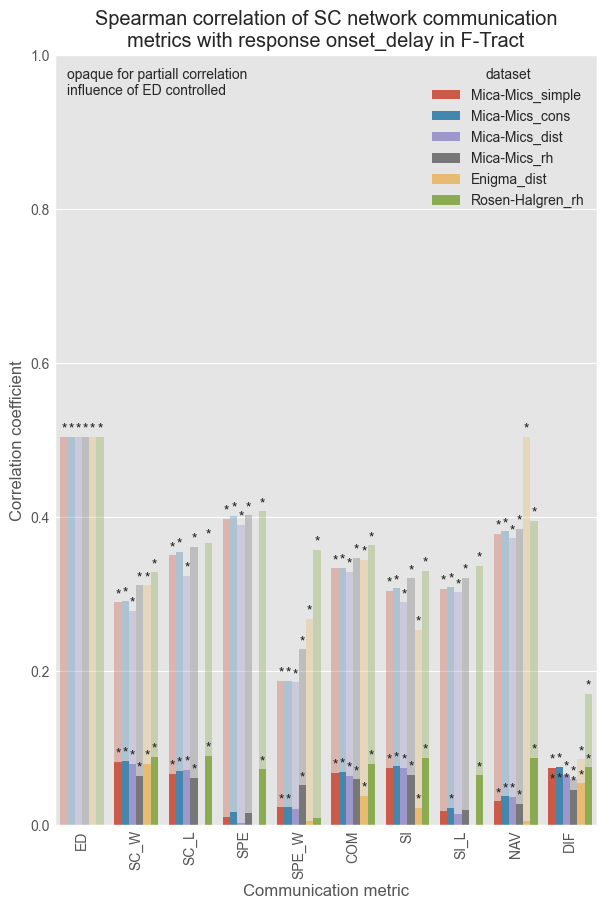

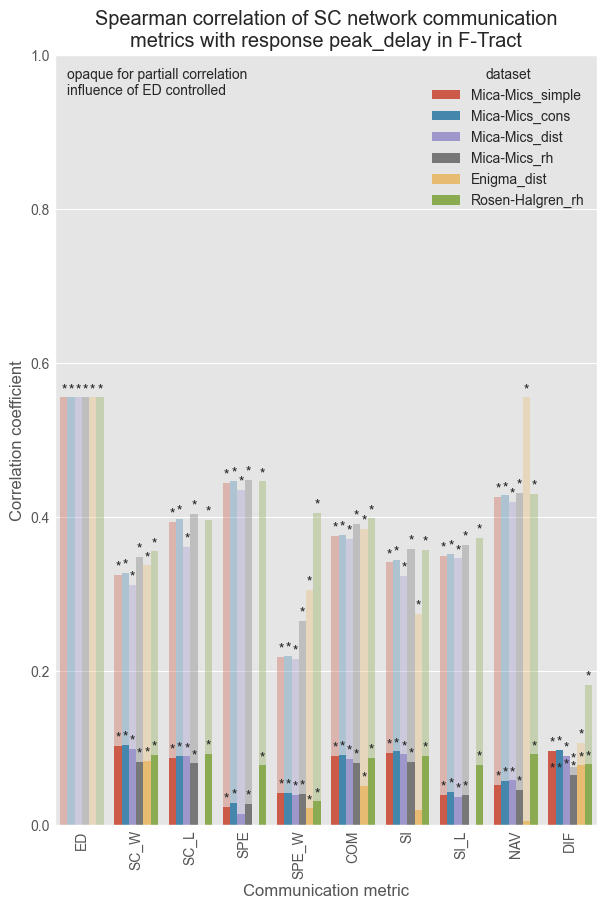

In [17]:
plt.style.use('ggplot')

for response_type in response_types_list:
    t = f"Spearman correlation of SC network communication\nmetrics with response {response_type} in F-Tract"
    plotting.plot_results_overlay(results[response_type],results_partial[response_type],title=t,fig_dir=fig_dir)